## Objective

우리가 아이폰 11을 팔아야 하는 마케터라고 상상해봅시다. 아이폰 11에 대한 랜딩 페이지를 기획하는 중에 있습니다. 팀원들과 토의하는 중, 아래와 같이 총 3개의 제품 스틸컷이 나왔습니다.

<img src="https://imgur.com/OVABmio.png" width="500">

이 3개 중에서 하나를 골라야 하는데, 도대체 어떤 이미지가 고객들이 가장 좋아할 만한 이미지인지 선택하기 어렵습니다. *우리는 어떤 식으로 제품 스틸컷을 골라야 할까요?*

### A/B Testing

위와 같은 상황에서 제일 좋은 방식은 직접 고객들에게 노출시킨 후 그 반응을 확인하는 것입니다. 고객들에게 무작위로 여러 버전(A,B)들을 제시하고, 고객의 반응을 정량적으로 측정하는 방식을 **A/B Testing**이라 합니다.

<img src="https://images.ctfassets.net/zw48pl1isxmc/4QYN7VubAAgEAGs0EuWguw/165749ef2fa01c1c004b6a167fd27835/ab-testing.png" width="500">


하지만 고객에게 A/B Testing을 할 때에는 우리는 **기회비용**을 항상 고민해야 합니다. 테스팅 과정을 수행하면서 좋지 못한 버전에 노출된 고객들은 우리가 놓쳐 버린 고객들이 됩니다. 그래서 적은 횟수로 빠르게 어떤 버전이 좀 더 고객들에게 좋은 반응을 얻고 있는지를 우리는 알고 싶습니다. 이러한 유형의 문제들을 통칭해 멀티 암드 밴딧(multi armed bandit)이라 합니다.

### 멀티 암드 밴딧

<img src="https://paperswithcode.com/media/thumbnails/task/task-0000000902-cfda1c60_HmUi8CF.jpg" width="300">

멀티 암드 밴딧은 아래와 같이 요약할 수 있습니다.

> N 개의 선택지가 존재한다. 각 선택지를 선택했을 때 이익은 다르다. 하지만 나는 각 선택지 별 이익이 어떠한지 지금 모른다. 여기서 어떤 선택지를 골랐을 때 가장 이익을 많이 얻을 수 있을까? 최적으로 선택지를 고르는 방법을 모색해 보자. 

우리가 최대의 이익을 얻는 방법은 **항상 이익이 가장 큰 선택지를 고르는 것**입니다. 하지만 우리는 어떤 선택이 이익이 큰지 모르기 때문에, 각 선택지 별로 이익의 크기를 탐색하는 과정을 거쳐야 합니다. 최소한의 탐색 횟수로 각 선택지의 이익이 얼마나 될지를 추론하는 것이 핵심이 됩니다.


## 멀티 암드 밴딧의 해결책 : 톰슨 샘플링

이 때 가장 많이 쓰이는 알고리즘이 바로 톰슨 샘플링입니다. 매번 선택을 하면서, 각각의 선택지에 대한 확률을 추론하는 알고리즘입니다. 톰슨 샘플링은 베타 분포라는 확률 분포를 이용합니다. 베타 분포가 어떤 의미를 가지는지는 아래를 통해 보도록 하겠습니다.


In [38]:
# 필요한 라이브러리 가져오기
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import beta
from tensorflow.keras.utils import get_file

import matplotlib.pyplot as plt

### 베타 분포란?

베타 분포는 $\alpha$와 $\beta$라는 두 모수를 가지며 표본 공간은 0과 1 사이의 실수인 분포입니다.

$$
Beta(x;\alpha,\beta) = \frac{1}{B(\alpha,\beta)}x^{(\alpha-1)}(1-x)^{(\beta-1)}
$$

Beta 분포는 모수 $\alpha$,$\beta$를 통해 기댓값, 분산, 최빈값을 쉽게 추론할 수 있습니다.

* 기댓값 : $E[x] = \frac{\alpha}{\alpha+\beta}$
* 분산 : $Var[x] = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$
* 최빈값 : $Mode[x] = \frac{\alpha-1}{\alpha+\beta-2}$

베타 분포는 **어떤 값에 대해 얼마나 확신하고 있는가**를 표현할 때 주로 쓰이는 분포입니다. 예를 들어, 우리가 복권을 긁어서 당첨될 확률을 알려고 한다고 해봅시다. 20번을 긁어서 1번 당첨됐을 때 "이 복권은 5% 확률로 당첨될 거 같아!" 라고 친구가 말하면, 그 말을 믿을 수 있을까요? 아마 그렇게 확신하긴 어려울 것입니다. 왜냐면 너무 적은 횟수로 시도했기 때문이죠. 이를 베타 분포로 표현하면 아래와 같습니다.

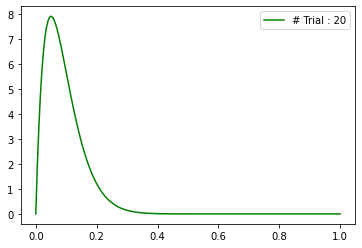

In [39]:
lucky = 1 # 성공한 횟수
fail  = 19 # 실패 횟수

dist_20 = beta(lucky+1, fail+1) # 베타 분포로 표현
xs = np.linspace(0,1,num=200)

plt.plot(xs, dist_20.pdf(xs), color='g', 
         label=f"# Trial : {lucky+fail}")
plt.legend()
plt.show()

이 분포에서 x축은 당첨될 확률을 의미하고, y축은 당첨될 확률에 대한 **확신의 수준**을 의미합니다. y축이 가장 높은 지점이 현재는 5%이지만, 아직은 완만하게 퍼져있습니다.

좀 더 시도를 많이해 60번을 해서, 3번을 성공했다고 해봅시다. 그러면 확률이 어떻게 변할까요?

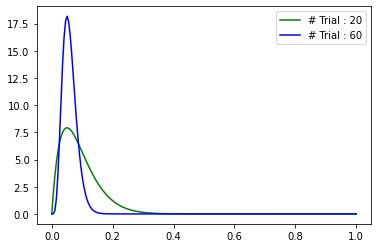

In [40]:
lucky = 3  # 성공한 횟수
fail  = 57 # 실패 횟수
dist_60 = beta(lucky+1, fail+1) # 베타 분포로 표현

plt.plot(xs, dist_20.pdf(xs), color='g', 
         label="# Trial : 20")
plt.plot(xs, dist_50.pdf(xs), color='b', 
         label="# Trial : 60")

plt.legend()
plt.show()

이러한 베타 분포를 이용해, 톰슨 샘플링은 각 선택지의 확률 분포를 계산합니다. 매 시도 때마다 베타 분포에 따라 가장 큰 이익을 산출하는 선택지를 선택해보고, 해당 선택지의 확률 분포를 갱신하게 됩니다. 글로는 이해하기 어려우니 밑에서 동작하는 프로그램을 통해 살펴보도록 하겠습니다.

## 예제 상황 ) 톰슨 샘플링으로 A/B Test 진행하기

<img src="https://imgur.com/OVABmio.png" width="500">

우리에게는 3가지 이미지가 있습니다. 세 이미지 모두 고객이 관심을 유도하여, 제품 페이지 클릭을 유도하기 위해 설계되어 있습니다. 즉 높은 클릭율(CTR)일수록 좋은 이미지입니다. 하지만 우리는 셋 중 어느 이미지가 높은 CTR을 가질지를 모릅니다. 이 때 우리는 어떻게 시도하는 것이 좋을까요?

마케팅 상황을 재현하기 위해 아래에 `simulator` 클래스를 구현하였습니다. 매 고객 별로 어떤 상품을 노출시키냐에 따라 클릭할지 안할지를 알려주는 역할을 합니다.

In [102]:
class Simulator:
    fpath = get_file(
        'ads_simulation.csv',
        'https://docs.google.com/uc?id=1uHFOZ0DTHaX45f26xCbj_G3eptRblXiu')
    simulation_cases = pd.read_csv(fpath)
    def __init__(self):
        self.idx = 0
        self.selections = ["case1", "case2", "case3"]
    
    def choose(self, selection):
        assert selection in self.selections
        self.idx += 1
        idx = self.idx % 10000
        return bool(self.simulation_cases.loc[idx,selection])
    
# 시뮬레이터 런치하기
simulator = Simulator()    

시뮬레이터의 `choose()`은 매번 고객에게 노출시킨 후 고객이 페이지를 클릭했는지 안했는지를 평가받는 메소드입니다. 아래와 같이 반복적으로 호출함으로써, 고객에 대한 반응을 수집할 수 있습니다.

In [103]:
print(" case1 만으로 고객에게 노출한 경우")
for i in range(5):
    result = simulator.choose('case1')
    print("  {}th 시도 : {}".format(i, result))
    
print("\n case2 만으로 고객에게 노출한 경우")
for i in range(5):
    result = simulator.choose('case2')
    print("  {}th 시도 : {}".format(i, result))    
    
print("\n case3 만으로 고객에게 노출한 경우")
for i in range(5):
    result = simulator.choose('case3')
    print("  {}th 시도 : {}".format(i, result))        

 case1 만으로 고객에게 노출한 경우
  0th 시도 : False
  1th 시도 : False
  2th 시도 : False
  3th 시도 : False
  4th 시도 : False

 case2 만으로 고객에게 노출한 경우
  0th 시도 : False
  1th 시도 : False
  2th 시도 : False
  3th 시도 : False
  4th 시도 : False

 case3 만으로 고객에게 노출한 경우
  0th 시도 : False
  1th 시도 : False
  2th 시도 : False
  3th 시도 : False
  4th 시도 : True


### 가장 쉽게 CTR을 구하는 방법 : 빈도 기반 확률 계산

각각 이미지 별로 1000번씩 고객에게 노출시켰다고 생각해 봅시다. 

In [104]:
case1_clicks = 0
for i in range(1000):
    case1_clicks += simulator.choose('case1')
case1_clicks / 1000

0.069

In [105]:
case2_clicks = 0
for i in range(1000):
    case2_clicks += simulator.choose('case2')
case2_clicks / 1000

0.212

In [106]:
case3_clicks = 0
for i in range(1000):
    case3_clicks += simulator.choose('case3')
case3_clicks / 1000

0.259

우리는 총 3000번의 시도를 통해, 3번째 이미지에 대한 CTR이 가장 높다는 것을 알아냈습니다. 우리가 처음부터 세번째 이미지의 CTR이 가장 높았다는 것을 알았더라면, 800여번을 클릭 횟수를 이루어냈을텐데, 실험하는 과정에서 반응이 좋지 못한 Case1과 Case2로 인해, 500여번의 훨씬 적은 클릭 횟수를 기록했습니다. 즉 우리는 300여번의 클릭을 놓친 셈이 됩니다. 이러한 것들은 기업의 입장에서는 모두 비용에 해당하게 됩니다. 이를 줄이는 방법이 바로 톰슨 샘플링입니다.

## 톰슨 샘플링 알고리즘 구현하기

톰슨 샘플링은 아래와 같이 굉장히 간단합니다. 이론은 어렵지만 구현은 굉장히 간단하죠. 

![](https://t4.daumcdn.net/thumb/R720x0/?fname=http://t1.daumcdn.net/brunch/service/user/IgT/image/zSSTskSW0U73xmBRHsYyHsPJHsQ.png)

### Thompson Sampling을 통한 CTR 추정하기

아래는 톰슨 샘플링을 1000번 시도한 결과입니다.

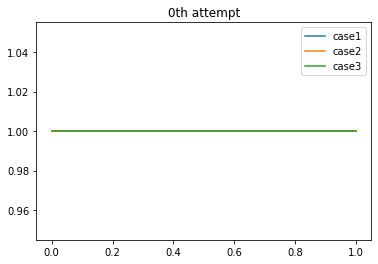

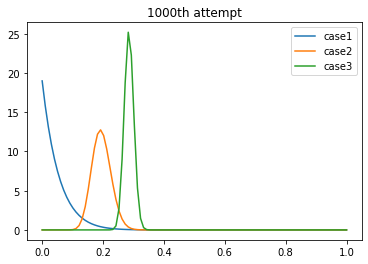

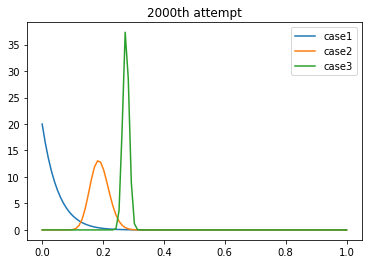

In [127]:
arms = pd.DataFrame(np.ones((3,2)), columns=['alpha','beta'],
                    index=['case1','case2','case3'])

clicks = 0
for idx in range(3000):
    # Visualization
    if idx % 1000 == 0:
        for name, row in arms.iterrows():
            xs = np.linspace(0+1e-5,1-1e-5,100)
            ys = beta.pdf(xs, row.alpha, row.beta)
            plt.plot(xs,ys,label=name)
        plt.title(f'{idx}th attempt')
        plt.legend()
        plt.show()
        
    # Sampling Model
    bandit_result = {name : np.random.beta(row.alpha, row.beta) 
                     for name, row in arms.iterrows()}
    
    # Select 
    chosen_model = pd.Series(bandit_result).idxmax()    
    
    # Update Distribution
    click = simulator.choose(chosen_model)
    clicks += click
    if click:
        # Success
        arms.loc[chosen_model,'alpha'] += 1
    else:
        # Fail
        arms.loc[chosen_model,'beta'] += 1        

톰슨 샘플링과정에서 우리가 확인할 수 있는 것은 가장 반응이 좋지 못한 case1은 몇 번의 시도 후, 더이상 시도하지 않았고 반응이 비슷한 case2와 case3를 중심으로 고객들에게 노출시켰음을 알 수 있습니다. 즉 톰슨샘플링은 기대 효과가 가장 낮은 것들부터 확률적으로 제거해나갑니다. 그럼으로써 거의 Case3만 선택했을 때(최적 결과)와 근사한 수준으로 클릭 횟수를 이끌어냈습니다.

In [134]:
print("각 이미지 별 시도 횟수")
print((arms.alpha+arms.beta-2).astype(int))
print("")

print(f"3000번 중 클릭 횟수 : {int(arms.alpha.sum() - 3)}건")

각 이미지 별 시도 횟수
case1      19
case2     164
case3    2817
dtype: int64

3000번 중 클릭 횟수 : 810건
